Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CSE291_HW3/dataset/models.zip
!unzip /content/drive/MyDrive/CSE291_HW3/dataset/testing_data_final.zip
!unzip /content/drive/MyDrive/CSE291_HW3/dataset/testing_data_pose.zip
!unzip /content/drive/MyDrive/CSE291_HW3/dataset/training_data.zip

!cp -r /content/drive/MyDrive/CSE291_HW3/benchmark_utils/ .
!cp /content/drive/MyDrive/CSE291_HW3/utils.py .
!cp /content/drive/MyDrive/CSE291_HW3/chamfer.py .

!pip install open3d
!pip install transforms3d
!pip install pillow

In [ ]:
!cp -r /content/drive/MyDrive/CSE291_HW3/benchmark_utils/ .
!cp /content/drive/MyDrive/CSE291_HW3/utils.py .
!cp /content/drive/MyDrive/CSE291_HW3/chamfer.py

cp: missing destination file operand after '/content/drive/MyDrive/CSE291_HW3/chamfer.py'
Try 'cp --help' for more information.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading Data

In [ ]:
import json
import multiprocessing
import os
import pickle
from collections import defaultdict
from multiprocessing import Manager, Pool
from multiprocessing.managers import SyncManager
from operator import attrgetter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import open3d
from PIL import Image
from tqdm import tqdm

import utils
from benchmark_utils import pose_utils
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation as R
import warnings


In [ ]:
testing_data_dir = "./testing_data_pose_filtered/testing_data/v2.2"
split_dir = "./training_data_filtered/training_data/splits/v2"
training_data_dir = "./training_data_filtered/training_data/v2.2"


# Functions

In [ ]:
def get_split_files(training_data_dir,split_dir,split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

def np2o3d(points_viewer):
    # points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
    # colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
    points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
    pcd = open3d.geometry.PointCloud()
    pcd.points = points
    # pcd.colors = colors
    return pcd

def draw_bb(poses_world,meta,rgb):
    box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])
    boxed_image = np.array(rgb)
    for i in range(len(poses_world)):
        utils.draw_projected_box3d(
            boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
            thickness=2)
    # plt.plot(Image.fromarray((boxed_image * 255).astype(np.uint8)))
    return(Image.fromarray((boxed_image * 255).astype(np.uint8)))

def point_cloud_image_in_c(meta,depth):
    intrinsic = meta['intrinsic']
    z = depth
    v, u = np.indices(z.shape)
    uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
    points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
    return(points_viewer)

def align_rotation_matrix(vec1, vec2):
    """get rotation matrix between two vectors using scipy
    vec1->source
    vec2->target
    """
    vec1 = np.reshape(vec1, (1, -1))
    vec2 = np.reshape(vec2, (1, -1))
    r = R.align_vectors(vec2, vec1)
    return r[0].as_matrix()

def rot_align_via_PCA(src,tgt):
    try:
        pca = PCA(n_components=3)
        pca.fit(src)
        eig_vec = pca.components_
        normal_src = eig_vec[2, :] 
        pca = PCA(n_components=3)
        pca.fit(tgt)
        eig_vec = pca.components_
        normal_tgt = eig_vec[2, :] 
        return(align_rotation_matrix(normal_src, normal_tgt))
    except:
        return(np.eye(3))
    

def get_best_transform(pcd,obj,skip = 64,train_red_factor = 1):
    registrationResults = []
    init_t = np.eye(4)
    for pcd_tr in tqdm(point_cloud_dict[obj][::train_red_factor],leave=False):
        pcd_tr = pcd_tr[::skip]
        # pcd = pcd[::skip]
        shift = (np.mean(pcd,0)-np.mean(pcd_tr,0))
        init_t[:3,3] = shift
        init_t[:3,:3] = rot_align_via_PCA(pcd_tr,pcd)
        tmp = open3d.pipelines.registration.registration_icp(np2o3d(pcd_tr),
                                                             np2o3d(pcd),
                                                     0.2,init_t)        
        registrationResults.append([len(tmp.correspondence_set),tmp.inlier_rmse,tmp.transformation])
    registrationResults = np.array(registrationResults,dtype=object)
    if(not(np.all(registrationResults[:,0]==0))):
        registrationResults = registrationResults[np.squeeze(np.argwhere(registrationResults[:,0]!=0))]
    registrationResults = registrationResults[np.argsort(-registrationResults[:,0])[:len(registrationResults)//5]]
    T = np.copy(registrationResults[np.argmin(registrationResults[:,1])][2])
    # print(T,registrationResults[np.argmin(registrationResults[:,1])],registrationResults)
    # T[:3,3]+=shift
    return(T)


In [ ]:
rgb_files, depth_files, label_files, meta_files = get_split_files(training_data_dir,split_dir,'val')

In [ ]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

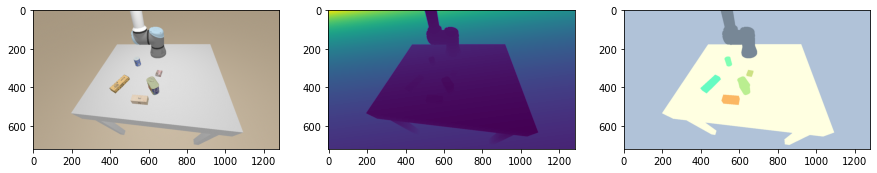

In [ ]:
rgb = np.array(Image.open(rgb_files[0])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[0]))
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

In [ ]:
label.shape

(720, 1280)

# Applying UNet

In [ ]:
import torch
from torch.nn import Conv2d
from torch import nn
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader


In [ ]:
class Unet(torch.nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.down1 = self.UnetDoubleConv(3,64)
        self.down2 = self.UnetDoubleConv(64,128)
        self.down3 = self.UnetDoubleConv(128,256)
        self.down4 = self.UnetDoubleConv(256,512)
        self.down5 = self.UnetDoubleConv(512,1024)
        
        self.up1 = self.UnetDoubleConv(64,82)
        self.up2 = self.UnetDoubleConv(128,64)
        self.up3 = self.UnetDoubleConv(256,128)
        self.up4 = self.UnetDoubleConv(512,256)
        self.up5 = self.UnetDoubleConv(1024,512)
        
#         self.upConvT1 = nn.ConvTranspose2d(64,)
        # self.upConvT2 = nn.ConvTranspose2d(128,64,2,2)
        # self.upConvT3 = nn.ConvTranspose2d(256,128,2,2)
        # self.upConvT4 = nn.ConvTranspose2d(512,256,2,2)
        # self.upConvT5 = nn.ConvTranspose2d(1024,512,2,2)
        
        self.upConvT2 = self.UnetUpConv(128,64)
        self.upConvT3 = self.UnetUpConv(256,128)
        self.upConvT4 = self.UnetUpConv(512,256)
        self.upConvT5 = self.UnetUpConv(1024,512)

        self.softmax = torch.nn.Softmax(dim=1)

        self.chut = nn.Conv2d(82,82,1,padding='same')

        
    def UnetDoubleConv(self,in_channels,out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def UnetUpConv(self,in_channels,out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,2,2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
            
    
    def forward(self,x):
        # x = x.permute(0, 3, 1, 2)
        convOut1 = self.down1(x)
        maxPool1 = nn.MaxPool2d(2)(convOut1)
        convOut2 = self.down2(maxPool1)
        maxPool2 = nn.MaxPool2d(2)(convOut2)
        convOut3 = self.down3(maxPool2)
        # maxPool3 = nn.MaxPool2d(2)(convOut3)
        # convOut4 = self.down4(maxPool3)
        # maxPool4 = nn.MaxPool2d(2)(convOut4)
        # convOut5 = self.down5(maxPool4)
#         maxPool5 = nn.MaxPool2d(2)(convOut5)
        
        
        # upPool4 = self.upConvT4(convOut4)
        # upPool4Cat = torch.cat([upPool4,convOut3],dim=1)
        # incConvOut3 = self.up4(upPool4Cat)
        # upPool3 = self.upConvT3(incConvOut3)
        upPool3 = self.upConvT3(convOut3)
        upPool3Cat = torch.cat([upPool3,convOut2],dim=1)
        incConvOut2 = self.up3(upPool3Cat)
        upPool2 = self.upConvT2(incConvOut2)
        upPool2Cat = torch.cat([upPool2,convOut1],dim=1)
        incConvOut1 = self.up2(upPool2Cat)
        
        out1 = self.up1(incConvOut1)
        out = self.chut(out1)
        # out = self.softmax(out)
        # out = out.permute(0,3,1,2)
        
        # upPool3 = self.upConvT3(incConvOut3)
        # incConvOut2 = self.up2(upPool3)
        
        return(out)
        

In [ ]:
multi_inputdevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet().to(multi_inputdevice)
summary(model,(3,180,320))
torch.cuda.empty_cache()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 180, 320]           1,792
       BatchNorm2d-2         [-1, 64, 180, 320]             128
              ReLU-3         [-1, 64, 180, 320]               0
            Conv2d-4         [-1, 64, 180, 320]          36,928
       BatchNorm2d-5         [-1, 64, 180, 320]             128
              ReLU-6         [-1, 64, 180, 320]               0
            Conv2d-7         [-1, 128, 90, 160]          73,856
       BatchNorm2d-8         [-1, 128, 90, 160]             256
              ReLU-9         [-1, 128, 90, 160]               0
           Conv2d-10         [-1, 128, 90, 160]         147,584
      BatchNorm2d-11         [-1, 128, 90, 160]             256
             ReLU-12         [-1, 128, 90, 160]               0
           Conv2d-13          [-1, 256, 45, 80]         295,168
      BatchNorm2d-14          [-1, 256,

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, rgb_files,label_files):
    super().__init__()
    self.image_names = rgb_files
    self.label_names = label_files

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    rgb = np.array(Image.open(self.image_names[idx]))
    rgb = rgb[::4,::4]
    img = (
      torch.tensor(rgb / 255.0, dtype=torch.float32)
      .permute(2, 0, 1)
      .contiguous()
    )
    if(not(self.label_names is None)):
      label = np.array(Image.open(self.label_names[idx]))
      label = label[::4,::4]
      lbl = torch.tensor(label, dtype=torch.int64).contiguous()
    else:
      lbl = None
    return {"image": img, "label": lbl}

In [ ]:
rgb_files, depth_files, label_files, meta_files = get_split_files(training_data_dir,split_dir,'train')
rgb_files_val, depth_files_val, label_files_val, meta_files_val = get_split_files(training_data_dir,split_dir,'val')

In [ ]:
batch_size = 8
dataset_train = Dataset(rgb_files,label_files)
trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,num_workers=2)
dataset_val = Dataset(rgb_files_val,label_files_val)
valloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True,num_workers=2)

In [ ]:
import datetime
print(f'saved_model_{datetime.datetime.now().strftime("%Y_%m_%dT%H_%M_%S")}')

saved_model_2022_12_07T03_46_19


In [ ]:
import datetime


torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet()
model = model.to(device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.004)

epochs= 10

min_valid_loss = np.inf


for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()
    with tqdm(trainloader, unit="batch") as tepoch:
      for data in tepoch:
        inputs, labels = data['image'],data["label"]
        tepoch.set_description(f"Epoch {epoch}")
        # trainset, valset = torch.utils.data.random_split(dataloader, [950,50])
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = inputs.to(device),labels.to(device)
        # labels = torch.unsqueeze(torch.div(labels,255),1)
        # labels = labels.type(torch.LongTensor)

        # print('a')
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print('b')

        # print statistics
        tepoch.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # if i % 100 == 0:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for data_val in valloader:
        # if torch.cuda.is_available():
        data, labels = data_val['image'],data_val["label"]
        data, labels = data.to(device), labels.to(device)
        
        target = model(data)
        loss = criterion(target,labels)
        valid_loss = loss.item() * data.size(0)

    print(f' Validation Loss: {valid_loss / len(valloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        # torch.save(model.state_dict(), '/content/drive/Othercomputers/My PC/UCSD Acads/Quarter 1/CSE 291/HW3/saved_model.pth')
        torch.save(model.state_dict(), f'/content/drive/Othercomputers/My PC/UCSD Acads/Quarter 1/CSE 291/HW3/saved_model_{datetime.datetime.now().strftime("%Y_%m_%dT%H_%M_%S")}_valloss_{valid_loss}.pth')

    # model.eval()
    # with tqdm(valloader, unit="batch") as tepoch:
    #   for inputs, labels in tepoch:
    #     tepoch.set_description(f"Epoch {epoch}")


Epoch 0: 100%|██████████| 496/496 [03:12<00:00,  2.57batch/s, loss=0.00666]


 Validation Loss: 0.04915046691894531
Validation Loss Decreased(inf--->1.474514) 	 Saving The Model


Epoch 1: 100%|██████████| 496/496 [03:19<00:00,  2.49batch/s, loss=0.00175]


 Validation Loss: 0.0005016292755802473
Validation Loss Decreased(1.474514--->0.015049) 	 Saving The Model


Epoch 2: 100%|██████████| 496/496 [03:20<00:00,  2.47batch/s, loss=0.00443]


 Validation Loss: 0.0004614901108046373
Validation Loss Decreased(0.015049--->0.013845) 	 Saving The Model


Epoch 3: 100%|██████████| 496/496 [03:20<00:00,  2.47batch/s, loss=0.000632]


 Validation Loss: 0.10935432910919189


Epoch 4: 100%|██████████| 496/496 [03:21<00:00,  2.47batch/s, loss=0.000317]


 Validation Loss: 0.024516244729359944


Epoch 5: 100%|██████████| 496/496 [03:21<00:00,  2.46batch/s, loss=0.0473]


 Validation Loss: 0.008822189768155415


Epoch 6: 100%|██████████| 496/496 [03:20<00:00,  2.47batch/s, loss=0.0102]


 Validation Loss: 0.002028158058722814


Epoch 7:  74%|███████▎  | 365/496 [02:28<00:52,  2.47batch/s, loss=0.00398]<ipython-input-11-7b7fea59fc04>:11: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'PngImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  rgb = np.array(Image.open(self.image_names[idx]))
Epoch 7:  74%|███████▎  | 365/496 [02:28<00:53,  2.46batch/s, loss=0.00398]


KeyboardInterrupt: ignored

## Inference Tesing

In [ ]:
iter_val = iter(trainin )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
d = dataset_val[0]
rgb = d['image']
label = d['label']
model.eval()
pred_label = np.argmax(np.transpose(np.squeeze(model(torch.unsqueeze(rgb,0).to(device)).cpu().detach().numpy(),0),(1,2,0)),-1)
# pred_label = 
# model.eval()
# test_labels = np.argmin(np.transpose(model(torch.tensor(np.transpose(test_images,(0,3,1,2))).float().to(device)).detach().cpu().numpy(),(0,2,3,1)),axis=-1)*255

plt.figure(figsize=(30, 20))
plt.subplot(1, 3, 1)
plt.imshow(np.transpose(rgb,(1,2,0)))
plt.subplot(1, 3, 2)
plt.imshow(COLOR_PALETTE[label])
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[pred_label])  # draw colorful segmentation

NameError: ignored

## Test Testing

## Prediction from Weights 

In [ ]:
!ls  "/content/drive/Othercomputers/My PC/UCSD Acads/Quarter 1/CSE 291/HW3/"

HW3.pdf				     saved_model_2022_12_07T03_53_02.pth
saved_model_2022_12_07T03_23_55.pth  saved_model_2022_12_07T03_56_29.pth
saved_model_2022_12_07T03_49_37.pth


In [ ]:
model_loaded = Unet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pth_name = "saved_model_2022_12_07T03_56_29.pth"
model_loaded.load_state_dict(torch.load(f'/content/drive/Othercomputers/My PC/UCSD Acads/Quarter 1/CSE 291/HW3/{pth_name}',map_location=torch.device(device)))

model_loaded.to(device)

Unet(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
with open("./testing_data_pose_filtered/testing_data/test.txt",'r') as f:
    prefix = [os.path.join(testing_data_dir, line.strip()) for line in f if line.strip()]
    rgb_test_files = [p + "_color_kinect.png" for p in prefix]
    depth_test_files = [p + "_depth_kinect.png" for p in prefix]
    meta_test_files= [p + "_meta.pkl" for p in prefix]


In [ ]:
dataset_test = Dataset(rgb_test_files,None)

In [ ]:
rgb = np.array(Image.open(rgb_test_files[0])) / 255
model_loaded.eval()
rgb = torch.tensor(rgb,dtype=torch.float32).permute(2,0,1)
label = np.argmax(np.transpose(np.squeeze(model_loaded(torch.unsqueeze(rgb,0).to(device)).cpu().detach().numpy(),0),(1,2,0)),-1)


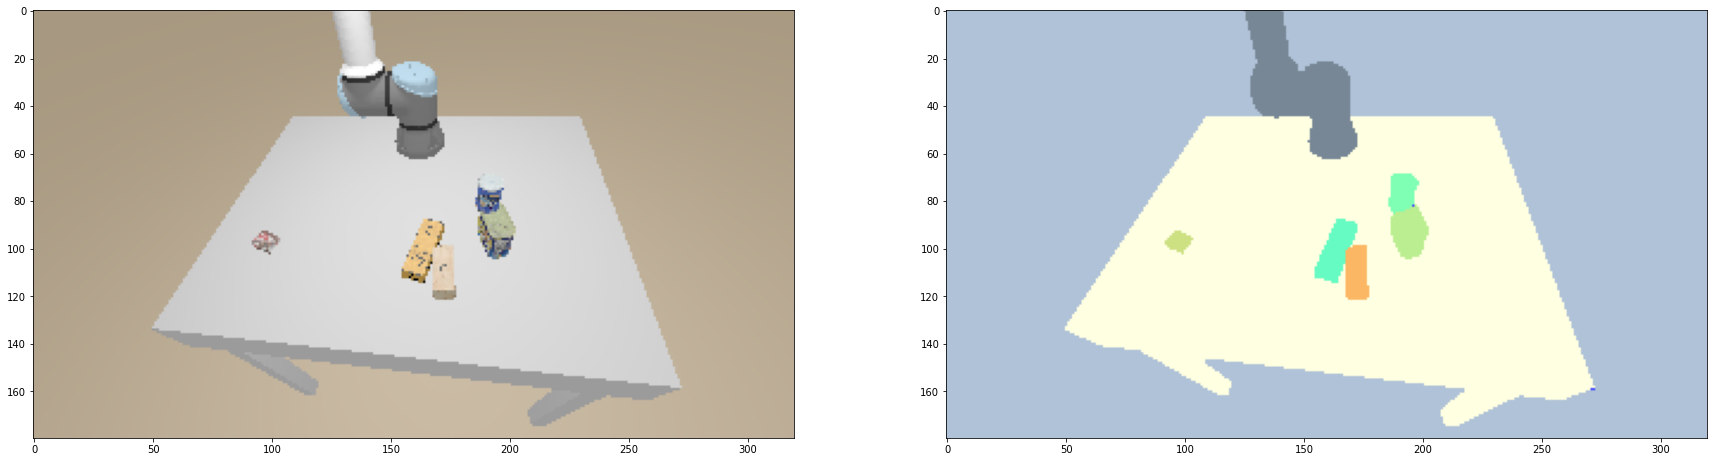

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rgb = dataset_train[0]['image']

model_loaded.eval()
pred_label = np.argmax(np.transpose(np.squeeze(model_loaded(torch.unsqueeze(rgb,0).to(device)).cpu().detach().numpy(),0),(1,2,0)),-1)
# pred_label = 
# model.eval()
# test_labels = np.argmin(np.transpose(model(torch.tensor(np.transpose(test_images,(0,3,1,2))).float().to(device)).detach().cpu().numpy(),(0,2,3,1)),axis=-1)*255

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(rgb,(1,2,0)))
# plt.subplot(1, 3, 2)
# plt.imshow(COLOR_PALETTE[label])
plt.subplot(1, 2, 2)
plt.imshow(COLOR_PALETTE[pred_label])  # draw colorful segmentation